In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

from numba import jit, cuda
import numba
import random
from numba.typed import List

In [2]:
def create_sudoku():
    base  = 3
    side  = base*base

    # pattern for a baseline valid solution
    def pattern(r,c): 
        return (base*(r%base)+r//base+c)%side

    # randomize rows, columns and numbers (of valid base pattern)
    def shuffle(s): 
        return random.sample(s,len(s)) 
    
    rBase = range(base) 
    rows  = [g*base + r for g in shuffle(rBase) for r in shuffle(rBase)] 
    cols  = [g*base + c for g in shuffle(rBase) for c in shuffle(rBase)]
    nums  = shuffle(range(1,base*base+1))

    # produce board using randomized baseline pattern
    board = [ [nums[pattern(r,c)] for c in cols] for r in rows ]

    return np.array(board)

def remove_sudoku(sudoku, porcentaje=.5):
    # remove numbers from sudoku
    sudoku = sudoku.copy()
    for i in range(9):
        for j in range(9):
            if np.random.rand() < porcentaje:
                sudoku[i,j] = 0
    return sudoku.astype(np.int64)

In [3]:
#@jit(target_backend='cuda') 
def fitness(solucion, tam=9):
    total = 0
    for i in range(tam):
        total += len(set(solucion[i]))
    for i in range(tam):
        total += len(set(solucion[:, i]))
    for i in range(0, 9, 3):
        for j in range(0, 9, 3):
            total += len(set(solucion[i:i+3, j:j+3].flatten()))

    return 3*tam**2-total

#@jit(target_backend='cuda') 
def randomFill(sudoku, tam=9):
    lista = np.arange(1, 10)
    sudoku = sudoku.copy()
    for i in range(tam):
        #x = list(np.setdiff1d(lista, list(set(sudoku[i]))))
        x = list(set(lista) - set(sudoku[i]))
        x = np.array(x)
        for j in range(tam):
            if(sudoku[i, j] == 0):
                v = np.random.choice(x)
                sudoku[i, j] = v
                x = np.delete(x, np.where(x == v)[0])
    return sudoku

#@jit(target_backend='cuda') 
def Tournament(poblacion):
    index = np.random.randint(0, len(poblacion), 2)
    if(fitness(poblacion[index[0]]) < fitness(poblacion[index[1]])):
        return poblacion[index[0]]
    return poblacion[index[1]]

#@jit(target_backend='cuda') 
def randomCross(sudoku1, sudoku2, tam=9, mutationRate=0.5):
    sudoku1 = sudoku1.copy()
    index = np.random.randint(0, tam, 2)
    
    if random.uniform(0,1) < mutationRate:
        
        for i in np.arange(index[0], index[1]):
            sudoku1[i] = sudoku2[i]
    return sudoku1

#@jit(target_backend='cuda')
def crossOver(sudokus, totalSolutions=100, mutationRate=0.9):
    s = [sudokus[0].copy()]
    for i in range(1, totalSolutions):
        uno = Tournament(sudokus)
        dos = Tournament(sudokus)
        s.append(randomCross(uno, dos))

    return s
    
#@jit(target_backend='cuda') 
def getFreePosition(sudoku, tam=9):
    dic = []
    for i in range(tam):
        array = []
        for j in range(tam):
            if(sudoku[i, j] == 0):
                array.append(j)
        if len(array) == 0:
            dic.append(List([-1]))
        else:
            dic.append(List(array))

    
    return List(dic)

#@jit(target_backend='cuda') 
def mutation(sudoku, noMoviles, tam=9, mutationRate=0.9):
    s = sudoku.copy()
    for i in range(tam):
        if  random.uniform(0,1)  < mutationRate:
            v = len(noMoviles[i]) 
            index =[0,0]
            index[0],index[1] = random.randint(0, v-1),random.randint(0, v-1)
            if index[0]<0 or index[1]<0:
                continue
            v = noMoviles[i][index[0]], noMoviles[i][index[1]]
            
            s[i, v[0]], s[i, v[1]] = s[i, v[1]], s[i, v[0]]
            x = 20

    return s
#@jit(target_backend='cuda') 
def mutate(padres, noMoviles):
    arr = [padres[0]]
    for i in range(1, len(padres)):
        arr.append(mutation(padres[i], noMoviles))
    return arr
                        
def selecction(padres):
    return sorted(padres, key=lambda x: fitness(x))

In [4]:
def geneticAlgorithm(sudoku,totalSolutions = 100,iteraciones=100,tam=9,mutationRate=0.9,takeBest=20):
    noMoviles = getFreePosition(sudoku)
    padres =  [randomFill(sudoku) for i in range(totalSolutions)] 

    resultados = []

    for i in range(iteraciones):
       
        padres = selecction(padres)
        resultados.append([padres[0], fitness(padres[0])])
        clear_output(wait=True)
        arr = np.array([fitness(x) for x in padres])
        print("std ", np.std(arr) , " mean ", np.mean(arr))
        print("Iteration: ",i, ",fitness: ", resultados[-1][1], end="\r")
        
        if( resultados[-1][1]==0):
            break
        padres = crossOver(padres[:takeBest],totalSolutions)
        padres = mutate(padres, noMoviles)
        
    return pd.DataFrame(resultados, columns=['sudoku', 'fitness'])

In [5]:
def plotSolution(sudoku,n = 9):        
    fig, ax = plt.subplots(figsize=(n, n))   
    ax.set_title('Sudoku') 
    ax.set_xlim(0,n)
    ax.set_ylim(0,n)
    major_ticks = np.arange(0, n, n/3)
    minor_ticks = np.arange(0, n, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.3)
    ax.grid(which='major', alpha=0.9,linewidth=2)
    for i in range(n):
        for j in range(n):
            text = ax.text(j+.5, i+.5, sudoku[i, j], ha="center", va="center", color="r")
    plt.show()

In [6]:
solucion = create_sudoku()
sudoku =  remove_sudoku(solucion, porcentaje=0.3)
df = geneticAlgorithm(sudoku,totalSolutions=1000,iteraciones=10000,takeBest=100,tam=9,mutationRate=0.5)
df.to_csv('resultados.csv')

std  4.285921021204193  mean  16.109


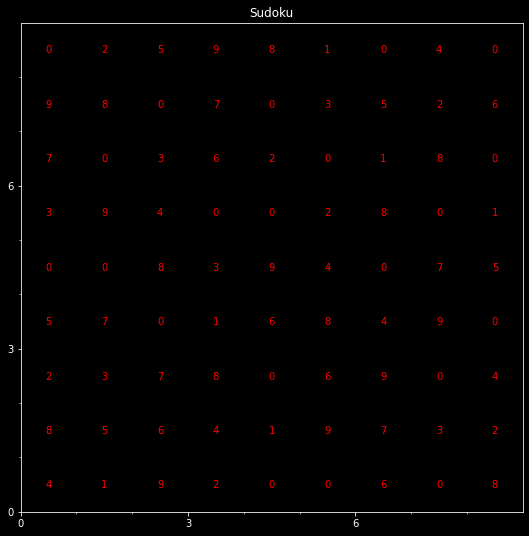

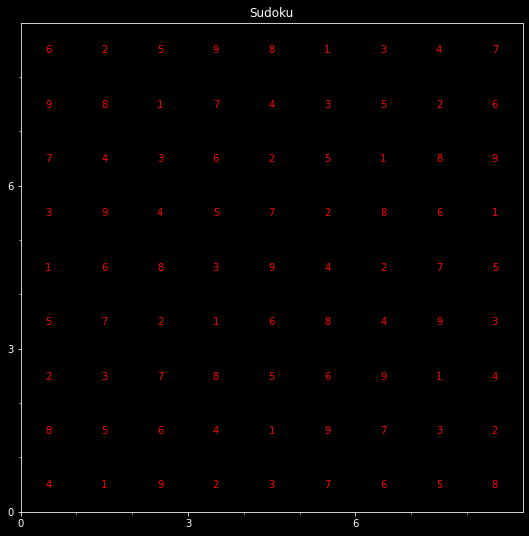

In [7]:
plotSolution(sudoku)
plotSolution(df.iloc[-1]['sudoku'])